<a href="https://colab.research.google.com/github/rishabhshah13/AIPI531/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torch torchvision numpy scipy scikit-learn matplotlib

In [4]:
!git clone https://github.com/mf1024/ImageNet-datasets-downloader.git

fatal: destination path 'ImageNet-datasets-downloader' already exists and is not an empty directory.


In [5]:
!mkdir /content/imagenet_images

mkdir: cannot create directory ‘/content/imagenet_images’: File exists


In [8]:
!mkdir /content/imagenet_images/batteldore_class /content/imagenet_images/peperomia_class

In [9]:
!python /content/ImageNet-datasets-downloader/downloader.py \
    -data_root /content/ \
    -use_class_list True \
    -class_list n00480885 n13150894 -images_per_class 100

n00480885
n13150894
Picked the following clases:
['battledore', 'peperomia']
Scraping images for class "battledore"
Multiprocessing workers: 8
Scraping images for class "peperomia"
Multiprocessing workers: 8


In [11]:
!mv /content/imagenet_images/battledore /content/imagenet_images/batteldore_class
!mv /content/imagenet_images/peperomia /content/imagenet_images/peperomia_class

In [12]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader

# Load the ResNet model
model = models.resnet34(pretrained=True)
model.eval()  # Set to evaluation mode

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load data
round_dataset = datasets.ImageFolder(root='/content/imagenet_images/batteldore_class', transform=transform)
# angular_dataset = datasets.ImageFolder(root='/content/imagenet_images','peperomia', transform=transform)
angular_dataset = datasets.ImageFolder(root='/content/imagenet_images/peperomia_class', transform=transform)

round_loader = DataLoader(round_dataset, batch_size=32, shuffle=True)
angular_loader = DataLoader(angular_dataset, batch_size=32, shuffle=True)


In [13]:
# !rm -rf /content/imagenet_images

In [27]:
# model

In [22]:
from torch import nn
import numpy as np

# Choose an intermediate layer for CAV analysis
layer_name = 'layer3'

# Hook to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hook for layer4
hook = model.layer4.register_forward_hook(get_activation(layer_name))

def extract_activations(loader):
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            model(inputs)
            features.append(activations[layer_name].cpu().numpy().mean(axis=(2, 3)))  # Global average
    return np.concatenate(features)

# Extract features for both concepts
round_features = extract_activations(round_loader)
angular_features = extract_activations(angular_loader)


In [23]:
from sklearn.linear_model import LogisticRegression

# Prepare labels (1 for round, 0 for angular)
X = np.vstack([round_features, angular_features])
y = np.array([1] * len(round_features) + [0] * len(angular_features))

# Train a logistic regression model as the CAV
cav_model = LogisticRegression().fit(X, y)
cav_round = cav_model.coef_[0]  # CAV for "round" concept
cav_angular = -cav_model.coef_[0]  # CAV for "angular" concept


In [24]:
from scipy.stats import ttest_ind

# Define a function to compute directional derivative
def directional_derivative(features, cav):
    return np.dot(features, cav)

# Test on images from the 'ball' class
ball_features = extract_activations(DataLoader(round_dataset, batch_size=32, shuffle=False))
dd_round = directional_derivative(ball_features, cav_round)
dd_angular = directional_derivative(ball_features, cav_angular)

# Perform a t-test
t_stat, p_value = ttest_ind(dd_round, dd_angular)
print(f"T-test between round and angular: t={t_stat}, p={p_value}")


T-test between round and angular: t=55.62384251346806, p=6.064156122742038e-76


In [25]:
import matplotlib.pyplot as plt
import cv2

# Grad-CAM helper
def grad_cam(input_image, model, target_layer):
    global activations # Access the global activations dictionary
    model.eval()
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    model.zero_grad()
    output = model(input_image)
    class_idx = output.argmax().item()
    output[0, class_idx].backward()  # Backpropagate the target class

    # Gradients and activations from the target layer
    gradients = model.layer4[1].conv2.weight.grad
    activations_layer = activations[target_layer] # Use a different variable name

    # Global average pooling on gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations_layer.shape[1]): # Use the new variable name
        activations_layer[:, i, :, :] *= pooled_gradients[i] # Use the new variable name

    heatmap = torch.mean(activations_layer, dim=1).squeeze().cpu().numpy() # Use the new variable name
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
    heatmap = heatmap / heatmap.max()  # Normalize

    return heatmap

# Plot Grad-CAM
def plot_grad_cam(image, heatmap):
    plt.figure()
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.imshow(heatmap, cmap='jet', alpha=0.4)  # Overlay heatmap
    plt.axis('off')
    plt.show()

<ipython-input-25-ae1ad9cad710>:26: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / heatmap.max()  # Normalize


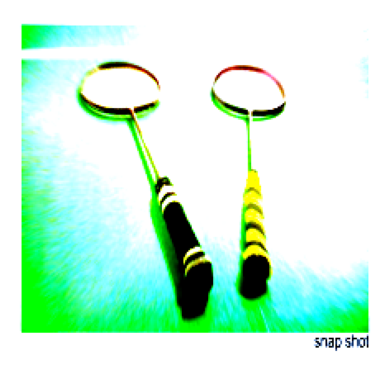

In [26]:
# Load an example image
ball_image, _ = round_dataset[0]
heatmap = grad_cam(ball_image, model, target_layer=layer_name)
plot_grad_cam(ball_image, heatmap)

In [30]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Concept Activation Vectors (CAVs) setup
def compute_cav(concept_images, random_images, model, layer_name='layer4'):
    # Extract features for concept and random images
    concept_features = extract_features(concept_images, model, layer_name)
    random_features = extract_features(random_images, model, layer_name)

    # Fit a linear classifier to distinguish between concept and random features
    from sklearn.linear_model import SGDClassifier
    X = np.concatenate([concept_features, random_features])
    y = np.array([1] * len(concept_features) + [0] * len(random_features))

    clf = SGDClassifier(max_iter=1000, tol=1e-3)
    clf.fit(X, y)

    # CAV is the normal to the decision boundary of this classifier
    cav = clf.coef_

    return cav

# Function to extract features from a specific layer
def extract_features(images, model, layer_name):
    features = []

    def hook(module, input, output):
        # Flatten the output tensor before appending to features
        features.append(output.detach().cpu().numpy().flatten()) # Flatten the features here

    handle = getattr(model, layer_name).register_forward_hook(hook)

    with torch.no_grad():
        for img in images:
            model(img)

    handle.remove()

    return np.array(features) # No need to squeeze as it's already flattened


# Example usage with paths to concept and random images
concept_images = [load_image('/content/imagenet_images/batteldore_class/battledore/1018535631_f6d5728522.jpg'), load_image('/content/imagenet_images/batteldore_class/battledore/150980392_1e03c82496.jpg')]
random_images = [load_image('/content/imagenet_images/peperomia_class/peperomia/1534374174_862e26fb69.jpg'), load_image('/content/imagenet_images/peperomia_class/peperomia/2349828462_ae346e5f3e.jpg')]

cav = compute_cav(concept_images, random_images, model)

# Function to test CAV on a new image
def test_cav(image_path, cav, model, layer_name='layer4'):
    image = load_image(image_path)

    # Extract features from the specified layer
    features = extract_features([image], model, layer_name)

    # Compute dot product with CAV to see alignment with concept
    dot_product = np.dot(features.flatten(), cav.flatten())

    return dot_product

# Test CAV on a new image (replace with actual image path)
result = test_cav('/content/imagenet_images/peperomia_class/peperomia/3090697333_18ff371efc.jpg', cav, model)
print(f"CAV alignment score: {result}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CAV alignment score: -117431.25
